# BOM_wet_dry_times

This notebook uses gridded daily BoM data to find wet and dry seasons based off the available range of gridded BoM data (1987 - 2013). Wet seasons are those in the 95th percentile of all seasonal rainfall. Dry seasons are those in the bottom 5th percentile.

** Code dependencies **
- csv file containing the bounding boxes for the case study site/s

** Accompanying code **
- BOM_wet_dry_times_loop_sites.ipynb - loops through csv of case study site locations

Created by Claire Krause. November 2016. Datacube version 1.1.13. Python v3

In [1]:
# Import the librarys we need for our analysis
%matplotlib inline
import datacube
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas
import csv
import logging
logging.getLogger('datacube.storage.storage').setLevel(logging.ERROR)


dc = datacube.Datacube(app='dc-BOMrainfall')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://cek156@130.56.244.227:6432/datacube)>>>

## Import the list of case study sites and bounding boxes.¶

In [2]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites.csv', delimiter = ',')
print(names)

         Name  minlat  maxlat  minlon  maxlon
0  Blackwood2  -34.10  -32.70  116.40  118.40
1     Garford  -29.90  -29.23  133.15  134.70
2    Mandora1  -21.10  -18.87  120.90  127.00
3   Mandora1a  -20.03  -18.88  120.90  123.30
4   Murchison  -27.95  -25.49  114.75  119.30
5         Ord  -15.93  -15.05  128.30  129.29
6      TiTree  -23.04  -21.67  133.18  134.24
7    Daintree  -16.39  -16.09  145.21  145.42
8       Laura  -15.85  -14.43  143.42  144.89
9  Blackwood1  -34.40  -33.58  115.00  116.40


In [3]:
# Choose which site you want to perform this analysis for
num = 0
Studysite = names.ix[num]
print(Studysite)

# Now set up the query with the chosen study site
query = {'lat': (names.maxlat[num], names.minlat[num]), 
         'lon': (names.minlon[num], names.maxlon[num]), 
         'time': ('1987-01-01','2014-01-01') }
query

Name      Blackwood2
minlat         -34.1
maxlat         -32.7
minlon         116.4
maxlon         118.4
Name: 0, dtype: object


{'lat': (-32.700000000000003, -34.100000000000001),
 'lon': (116.40000000000001, 118.40000000000001),
 'time': ('1987-01-01', '2014-01-01')}

In [4]:
# Grab bom_rainfall_grids from the datacube
Studysite_rain = dc.load(product = 'bom_rainfall_grids', **query)
print(Studysite_rain)

<xarray.Dataset>
Dimensions:    (latitude: 28, longitude: 40, time: 9862)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 1987-01-03 ...
  * latitude   (latitude) float64 -32.73 -32.77 -32.83 -32.88 -32.93 -32.98 ...
  * longitude  (longitude) float64 116.4 116.5 116.5 116.6 116.6 116.7 116.7 ...
Data variables:
    rainfall   (time, latitude, longitude) float32 3.65442e-07 1.98084e-08 ...
Attributes:
    crs: EPSG:4326


# Resample the data so that it's at seasonal resolution

Resampling can be done at a number of frequencies. See http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases for options.

In [5]:
# Resample to 3 monthly data, starting with December
monthly_avg = Studysite_rain.resample('QS-DEC', dim = 'time', how = 'mean')
print(monthly_avg)

<xarray.Dataset>
Dimensions:    (latitude: 28, longitude: 40, time: 109)
Coordinates:
  * latitude   (latitude) float64 -32.73 -32.77 -32.83 -32.88 -32.93 -32.98 ...
  * longitude  (longitude) float64 116.4 116.5 116.5 116.6 116.6 116.7 116.7 ...
  * time       (time) datetime64[ns] 1986-12-01 1987-03-01 1987-06-01 ...
Data variables:
    rainfall   (time, latitude, longitude) float32 0.01685 0.00796653 ...


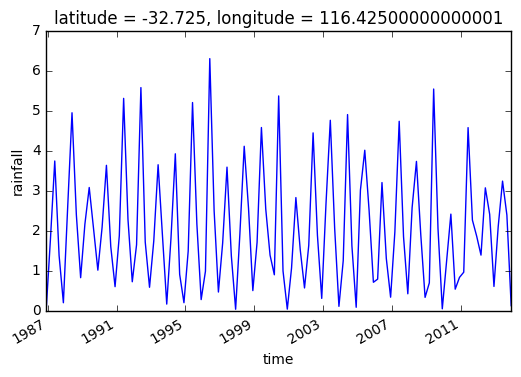

In [6]:
# Plot a random location to check the data looks ok. We have just chosen location (0,0) in the array
monthly_avg.isel(latitude = 0, longitude = 0).rainfall.plot()

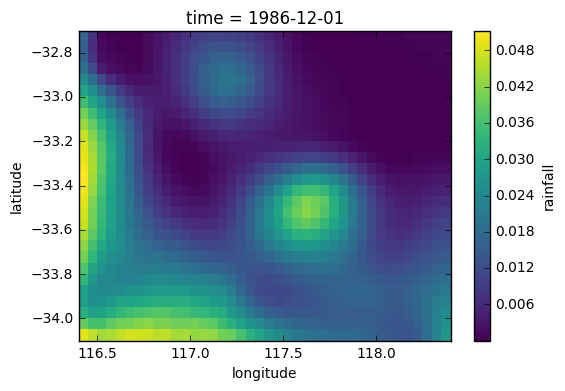

In [7]:
# Plot values across our box to check the spatial distribution
monthly_avg.isel(time = 0).rainfall.plot()

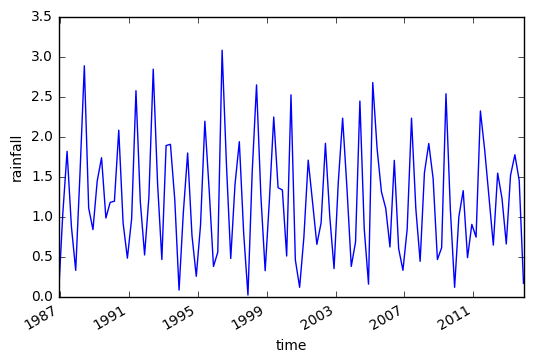

In [8]:
# Create an average across our whole bounding box - i.e. over lat and lon
monthly_avg_all = monthly_avg.mean(dim = ('latitude', 'longitude'))
monthly_avg_all
monthly_avg_all.rainfall.plot()

## Calculate the 5th and 95th percentile of rainfall and the seasons in which it occurred

In [9]:
# Find the 95th percentile
threshold95 = monthly_avg_all.reduce(np.percentile, dim = 'time', q = 95)
threshold95

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    *empty*
Data variables:
    rainfall  float64 2.559

In [10]:
# Find the 5th percentile
threshold5 = monthly_avg_all.reduce(np.percentile, dim = 'time', q = 5)
threshold5

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    *empty*
Data variables:
    rainfall  float64 0.1601

In [11]:
# Note that the resampling we did means that each season is labelled according to its first day 
# e.g. 1990-12-01 is Summer starting in Dec 1990.
wet_seasons = monthly_avg_all.where(monthly_avg_all.rainfall>=threshold95).dropna(dim = 'time')
print(wet_seasons.time.values)
dry_seasons = monthly_avg_all.where(monthly_avg_all.rainfall<=threshold5).dropna(dim = 'time')
print(dry_seasons.time.values)

['1988-06-01T00:00:00.000000000' '1991-06-01T00:00:00.000000000'
 '1992-06-01T00:00:00.000000000' '1996-06-01T00:00:00.000000000'
 '1998-06-01T00:00:00.000000000' '2005-03-01T00:00:00.000000000']
['1986-12-01T00:00:00.000000000' '1993-12-01T00:00:00.000000000'
 '1997-12-01T00:00:00.000000000' '2000-12-01T00:00:00.000000000'
 '2004-12-01T00:00:00.000000000' '2009-12-01T00:00:00.000000000']


In [12]:
dry = np.array(dry_seasons.time, dtype = 'datetime64[D]')
print(dry)
wet = np.array(wet_seasons.time, dtype = 'datetime64[D]')
print(wet)

['1986-12-01' '1993-12-01' '1997-12-01' '2000-12-01' '2004-12-01'
 '2009-12-01']
['1988-06-01' '1991-06-01' '1992-06-01' '1996-06-01' '1998-06-01'
 '2005-03-01']
